In [2]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# magic functions for jupyter notebook plotting
%load_ext autoreload
%autoreload 2
%matplotlib inline

# confirm that you are currently using the newest version of SDK (2.16.2)
import allensdk
print(allensdk.__version__)

import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"
    
    


2.16.2


In [3]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

cache = VisualBehaviorOphysProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)
# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

/opt/conda/lib/python3.10/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


In [4]:
# Get table describing ophys experiments 
ophys_experiment_table = cache.get_ophys_experiment_table()    

print('Number of ophys experiments = {}'.format(len(ophys_experiment_table)))

Number of ophys experiments = 1936


In [5]:
# This is our experiment from yesterday that had interesting looking activity
ophys_experiment_id = 993891832

# check the metadata to see what conditions it was imaged in
ophys_experiment_table.loc[ophys_experiment_id]


behavior_session_id                                                        993817409
ophys_session_id                                                           993790878
ophys_container_id                                                        1022733786
mouse_id                                                                      484631
indicator                                                                    GCaMP6f
full_genotype                      Slc17a7-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-G...
driver_line                                          [Slc17a7-IRES2-Cre, Camk2a-tTA]
cre_line                                                           Slc17a7-IRES2-Cre
reporter_line                                                     Ai93(TITL-GCaMP6f)
sex                                                                                F
age_in_days                                                                      156
imaging_depth                                                    

In [6]:
# Load the data using the cache
ophys_experiment = cache.get_behavior_ophys_experiment(ophys_experiment_id)

/opt/conda/lib/python3.10/site-packages/hdmf/utils.py:668: UserWarning: Ignoring cached namespace 'core' version 2.6.0-alpha because version 2.7.0 is already loaded.
  return func(args[0], **pargs)


In [7]:
# First get all the data we need

# Get normalized fluorescence traces
dff_traces = ophys_experiment.dff_traces.copy()

# Get deconvolved events
events = ophys_experiment.events.copy()

# Get timestamps 
ophys_timestamps = ophys_experiment.ophys_timestamps.copy()

# Get stimulus presentations
stimulus_presentations = ophys_experiment.stimulus_presentations.copy()

(2000.0, 2500.0)

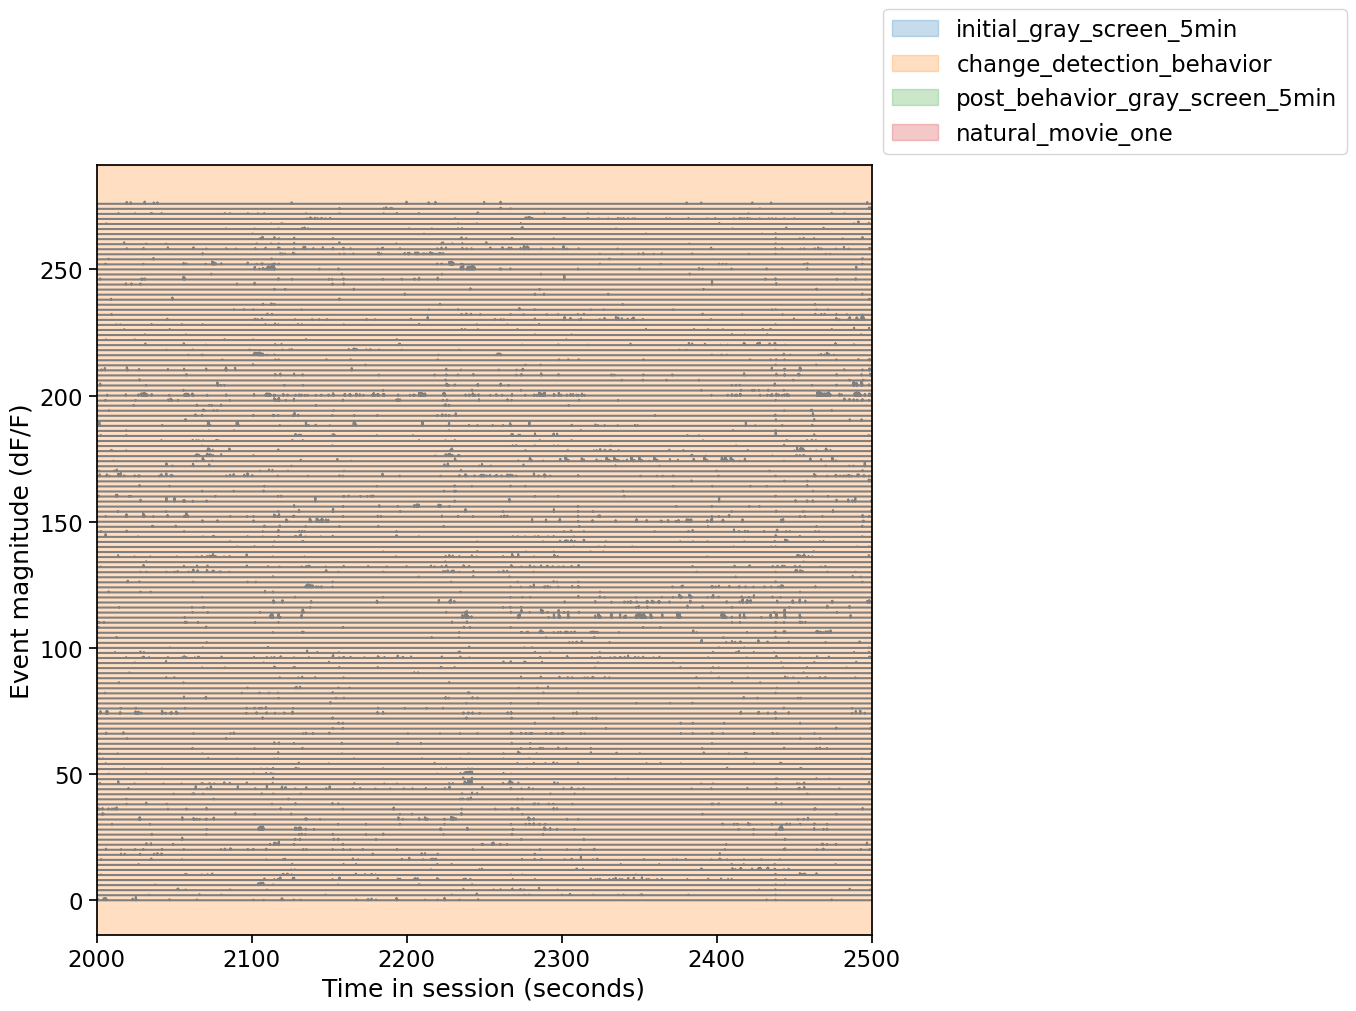

In [8]:
# Now plot events traces for all cells and plot stimulus blocks overlaid

# Plot events for all cells
fig, ax = plt.subplots(figsize=(10, 10))
for i, cell_specimen_id in enumerate(events.index.values): 
    ax.plot(ophys_timestamps, events.loc[cell_specimen_id]['events']+(i*2), color='gray')    

# Iterate through stimulus blocks and show them in color
colors = sns.color_palette()
for i, stimulus_block_name in enumerate(stimulus_presentations.stimulus_block_name.unique()): 
    stimulus_block_data = stimulus_presentations[stimulus_presentations.stimulus_block_name==stimulus_block_name]
    ax.axvspan(xmin=stimulus_block_data.start_time.values[0], xmax=stimulus_block_data.end_time.values[-1], 
               color=colors[i], alpha=0.25, label=stimulus_block_name)
ax.legend(bbox_to_anchor=(1,1))
ax.set_xlabel('Time in session (seconds)')
ax.set_ylabel('Event magnitude (dF/F)')


# Limit to our specified window
window_start = 2000
window_end = 2500
ax.set_xlim(window_start, window_end)

In [9]:
# Functions defined in day 1 intro

def plot_running_speed_in_window(running_speed, window_start, window_end, ax): 
    '''
    A function to plot running speed in specific window of time on the provided axis
    
    running_speed: A table including columns for `running_speed` and `timestamps`
    '''
    # Plot the running speed, in seconds, on the provided axis
    ax.plot(running_speed.timestamps, running_speed.speed)
    ax.set_ylabel('Running speed (cm/s)')
    ax.set_xlabel('Time in session (seconds)')
    # Limit to the selected window
    ax.set_xlim(window_start, window_end)

    # Return axes so we can add other things to it 
    return ax


def plot_licks_in_window(licks, window_start, window_end, ax): 
    '''
    A function to plot licks occuring in specific window of time on the provided axis
    
    licks: A table with timestamps of each lick in the session
    '''
    # Get licks in the provided window
    window_licks = licks[(licks.timestamps>=window_start) & (licks.timestamps<=window_end)]
    # Iterate through them and plot as a line
    for idx, lick in window_licks.iterrows():
        ax.plot(lick.timestamps, -0.75, '|', color='gray')

    # Return axes so we can add other things to it 
    return ax


def plot_rewards_in_window(rewards, window_start, window_end, ax): 
    '''
    A function to plot rewards occuring in specific window of time on the provided axis
    
    rewards: A table with timestamps of each reward in the session
    '''
    # Get rewards in the provided window
    window_rewards = rewards[(rewards.timestamps>=window_start) & (rewards.timestamps<=window_end)]
    # Iterate through them and plot as a line
    for idx, reward in window_rewards.iterrows():
        ax.plot(reward.timestamps, -1, 'o', color='cyan')

    # Return axes so we can add other things to it 
    return ax


def plot_stimuli_in_window(stimulus_presentations, window_start, window_end, ax): 
    '''
    A function to plot a colored bar for each unique image_name in a specific window of time
    within the provided stimulus_presentations table, on the provided axis. 
    
    stimulus_presentations: Table of all stimulus presentations and associated metadata
                            Function will limit to the `change_detection_behavior` block when image presentations occur
    '''

    # Make sure we are only looking at stimuli during the change detection block (other stimulus blocks do not have unique image names)
    stimulus_presentations = stimulus_presentations[(stimulus_presentations.stimulus_block_name=='change_detection_behavior')]

    # create colormap for unique image names
    colors = sns.color_palette('hls', len(stimulus_presentations.image_name.unique()))
    image_colors_dict = {}
    for i, image_name in enumerate(np.sort(stimulus_presentations.image_name.unique())): 
        # omissions are white
        if image_name == 'omitted': 
            image_colors_dict[image_name] = [1, 1, 1]
        # images are in color
        else: 
            image_colors_dict[image_name] = colors[i]

    # Get all stimuli in the provided window
    window_stimuli = stimulus_presentations[(stimulus_presentations.start_time>=window_start) & 
                                          (stimulus_presentations.end_time<=window_end)]

    # Loop through stimuli and plot them
    for idx, stimulus in window_stimuli.iterrows():
        image_name = stimulus['image_name']
        ax.axvspan(stimulus['start_time'], stimulus['end_time'], color=image_colors_dict[image_name], alpha=0.25)

    # Return axes so we can add other things to it   
    return ax

In [10]:
# Make functions to plot a cell's dff or events trace

def plot_cell_dff_trace_in_window(ophys_timestamps, dff_traces, cell_specimen_id, window_start, window_end, ax):
    '''
    A function to plot one cell's dF/F traces in a defined window, on the given axis
    
    ophys_timestamps: Array of timestamps corresponding to each ophys trace timepoint
    dff_traces: A table with dff_traces for each cell_specimen_id in the experiment
    cell_specimen_id: Which cell to plot
    window_start: start time, in seconds, of window for plot
    window_end: end time, in seconds, of window for plot
    '''
    # The cell_specimen_id is the index to the traces tables
    dff_trace = dff_traces.loc[cell_specimen_id]['dff']

    # Plot events and dF/F, in seconds
    ax.plot(ophys_timestamps, dff_trace, color='gray', label='dF/F')
    ax.set_xlabel('Time in session (seconds)')
    ax.set_ylabel('dF/F')

    # Limit to our specified window
    ax.set_xlim(window_start, window_end)

    # Put the cell ID in the title so we know who this cell is
    ax.set_title('cell_specimen_id: '+str(cell_specimen_id))
    
    return ax


def plot_cell_events_in_window(ophys_timestamps, events, cell_specimen_id, window_start, window_end, ax):
    '''
    A function to plot one cell's deconvolved events in a defined window, on the given axis
    
    ophys_timestamps: Array of timestamps corresponding to each ophys trace timepoint
    events: A table with deconvolved events for each cell_specimen_id in the experiment
    cell_specimen_id: Which cell to plot
    window_start: start time, in seconds, of window for plot
    window_end: end time, in seconds, of window for plot
    '''
    # The cell_specimen_id is the index to the traces tables
    events_trace = events.loc[cell_specimen_id]['events']

    # Plot events and dF/F, in seconds
    ax.plot(ophys_timestamps, events_trace, color=sns.color_palette()[0], label=events)
    ax.set_xlabel('Time in session (seconds)')
    ax.set_ylabel('Event magnitude (dF/F)')

    # Limit to our specified window
    ax.set_xlim(window_start, window_end)

    # Put the cell ID in the title so we know who this cell is
    ax.set_title('cell_specimen_id: '+str(cell_specimen_id))
    
    return ax

In [11]:
def plot_novelG_stimuli_in_window(stimulus_presentations, window_start, window_end, ax): 
    '''
    A function to plot a colored bar for each unique image_name in a specific window of time
    within the provided stimulus_presentations table, on the provided axis. 
    
    stimulus_presentations: Table of all stimulus presentations and associated metadata
                            Function will limit to the `change_detection_behavior` block when image presentations occur
    '''

    # Make sure we are only looking at stimuli during the change detection block (other stimulus blocks do not have unique image names)
    stimulus_presentations = stimulus_presentations[(stimulus_presentations.stimulus_block_name=='change_detection_behavior')]

    # create colormap for unique image names
    #colors = sns.color_palette('hls', len(stimulus_presentations.image_name.unique()))

    image_colors_dict = {}
    # for i, image_name in enumerate(np.sort(stimulus_presentations.image_name.unique())): 
    #     # omissions are white
    #     if image_name == 'omitted': 
    #         image_colors_dict[image_name] = [1, 1, 1]
    #     # images are in color
    #     if image_name in ['im083_r', 'im111_r']
    #         image_colors_dict[image_name] = colors1[i]
    #     else: 
    #         image_colors_dict[image_name] = colors2[i]
    color_keys = ['im036_r', 'im012_r', 'im044_r', 'im047_r', 'im115_r', 'im078_r', 'im083_r', 'im111_r', 'omitted']
    color_values = ['#ce0303','#df4b00', '#ec7500', '#f69c00', '#fcc100', '#ffe600', '#292f56', '#009590', '#FFFFFF']
    image_colors_dict = dict(zip(color_keys, color_values))
    
    # Get all stimuli in the provided window
    window_stimuli = stimulus_presentations[(stimulus_presentations.start_time>=window_start) & 
                                          (stimulus_presentations.end_time<=window_end)]

    # Loop through stimuli and plot them
    for idx, stimulus in window_stimuli.iterrows():
        image_name = stimulus['image_name']
        ax.axvspan(stimulus['start_time'], stimulus['end_time'], color=image_colors_dict[image_name], alpha=0.25)

    # Return axes so we can add other things to it   
    return ax

def plot_novelH_stimuli_in_window(stimulus_presentations, window_start, window_end, ax): 
    '''
    A function to plot a colored bar for each unique image_name in a specific window of time
    within the provided stimulus_presentations table, on the provided axis. 
    
    stimulus_presentations: Table of all stimulus presentations and associated metadata
                            Function will limit to the `change_detection_behavior` block when image presentations occur
    '''

    # Make sure we are only looking at stimuli during the change detection block (other stimulus blocks do not have unique image names)
    stimulus_presentations = stimulus_presentations[(stimulus_presentations.stimulus_block_name=='change_detection_behavior')]

    # create colormap for unique image names
    #colors = sns.color_palette('hls', len(stimulus_presentations.image_name.unique()))

    image_colors_dict = {}
    # for i, image_name in enumerate(np.sort(stimulus_presentations.image_name.unique())): 
    #     # omissions are white
    #     if image_name == 'omitted': 
    #         image_colors_dict[image_name] = [1, 1, 1]
    #     # images are in color
    #     if image_name in ['im083_r', 'im111_r']
    #         image_colors_dict[image_name] = colors1[i]
    #     else: 
    #         image_colors_dict[image_name] = colors2[i]
    color_keys = ['im104_r', 'im114_r', 'im005_r', 'im087_r', 'im024_r', 'im034_r', 'im083_r', 'im111_r', 'omitted']
    color_values = ['#f5ef47','#f47906', '#9C0707', '#910040', '#cf6c00', '#fd1c1c', '#55f047', '#00cee7', '#FFFFFF']
    image_colors_dict = dict(zip(color_keys, color_values))
    
    # Get all stimuli in the provided window
    window_stimuli = stimulus_presentations[(stimulus_presentations.start_time>=window_start) & 
                                          (stimulus_presentations.end_time<=window_end)]

    # Loop through stimuli and plot them
    for idx, stimulus in window_stimuli.iterrows():
        image_name = stimulus['image_name']
        ax.axvspan(stimulus['start_time'], stimulus['end_time'], color=image_colors_dict[image_name], alpha=0.25)

    # Return axes so we can add other things to it   
    return ax

Text(0.5, 0, 'Time (s)')

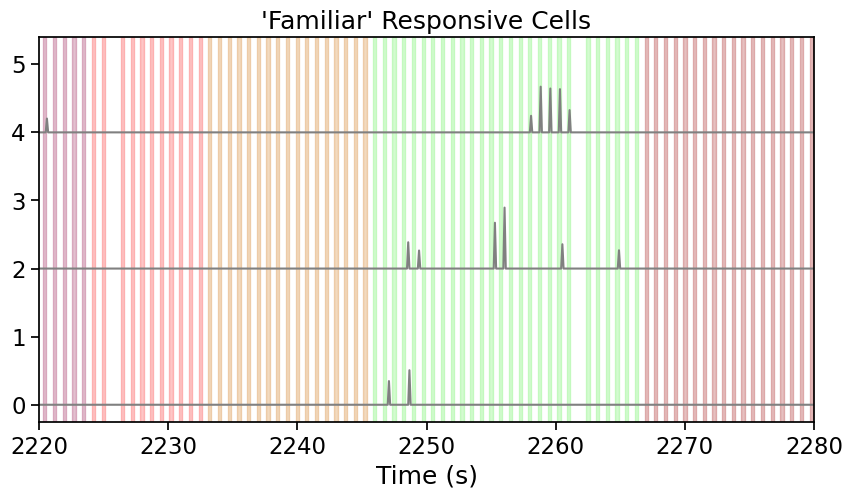

In [17]:
# Plot events for familiar responsive cells
fig, ax = plt.subplots(figsize=(10, 5))
novel_responsive = [4, 14, 16, 20, 25, 33, 40, 56, 57, 66, 68,104, 131, 133]

familiar_responsive = [6, 11, 108]

#for i, cell_specimen_id in enumerate(events.index.values): 
for i, cell_specimen_id in enumerate(events.index.values[familiar_responsive]): 
    ax.plot(ophys_timestamps, events.loc[cell_specimen_id]['events']+(i*2), color='gray') 
    
# Limit to our specified window
window_start = 2220
window_end = 2280
ax.set_xlim(window_start, window_end)

# Plot stimuli using function we created, for the subset of stimuli we selected
ax = plot_novelH_stimuli_in_window(stimulus_presentations, window_start, window_end, ax)

# Plot licks in the window we selected
#ax = plot_licks_in_window(ophys_experiment.licks, window_start, window_end, ax)

# Plot rewards in the window we selected
#ax = plot_rewards_in_window(ophys_experiment.rewards, window_start, window_end, ax)

ax.set_title("'Familiar' Responsive Cells")

ax.set_xlabel('Time (s)')

Text(0.5, 0, 'Time (s)')

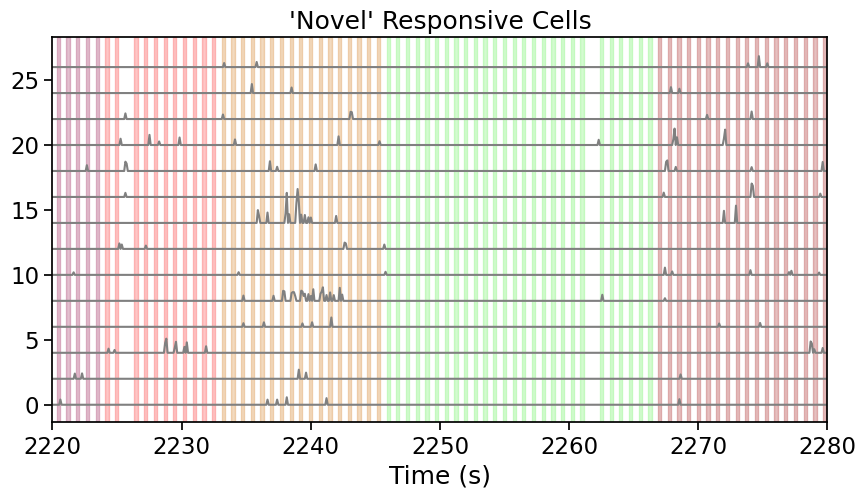

In [16]:
# Plot events for novel responsive cells
fig, ax = plt.subplots(figsize=(10, 5))
novel_responsive = [4, 14, 16, 20, 25, 33, 40, 56, 57, 66, 68,104, 131, 133]
# remove 0,23,
familiar_responsive = [6, 11, 108, 138]

#for i, cell_specimen_id in enumerate(events.index.values): 
for i, cell_specimen_id in enumerate(events.index.values[novel_responsive]): 
    ax.plot(ophys_timestamps, events.loc[cell_specimen_id]['events']+(i*2), color='gray') 
    
# Limit to our specified window
window_start = 2220
window_end = 2280
ax.set_xlim(window_start, window_end)

# Plot stimuli using function we created, for the subset of stimuli we selected
ax = plot_novelH_stimuli_in_window(stimulus_presentations, window_start, window_end, ax)

# Plot licks in the window we selected
#ax = plot_licks_in_window(ophys_experiment.licks, window_start, window_end, ax)

# Plot rewards in the window we selected
#ax = plot_rewards_in_window(ophys_experiment.rewards, window_start, window_end, ax)

ax.set_title("'Novel' Responsive Cells")

ax.set_xlabel('Time (s)')

In [15]:
events

,cell_roi_id,events,filtered_events,lambda,noise_std
cell_specimen_id,,,,,
1120110190,1115402795,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0600,0.085220
1120119513,1115402802,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.3997350462730751, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.2876755370796479, ...",0.0395,0.069125
1120119456,1115402811,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0815,0.099193
1120114879,1115402819,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0657,0.089271
1120122333,1115402834,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.1739,0.145206
...,...,...,...,...,...
1120111032,1115403715,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0557,0.082016
1120110808,1115403716,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5014995620412...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3609119520555...",0.0594,0.084680
1120110389,1115403731,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0658,0.089152
